In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from tqdm import tqdm
import copy
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import RandomFeatureModel
from train import train
from sampling import sample_exponential

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
data = torch.tensor([[0.0,0.0],[5.0, 0.0],[0.0, 5.0]], device=device)
data_repeated = data.repeat_interleave(2000, dim=0)
input_dim = 2
time_emb_dim = 128 #这是之前使用正弦编码用到的参数
T = 40.0
K_t = 64


=== Training Model 1/4 with t_grid_size=100 ===


  0%|          | 0/20000 [00:00<?, ?it/s]

Creating individual and combined visualizations for Model 1...
✅ Saved individual plot: model_t_grid_size_100_visualization.png

=== Training Model 2/4 with t_grid_size=200 ===


  0%|          | 0/20000 [00:00<?, ?it/s]

Creating individual and combined visualizations for Model 2...
✅ Saved individual plot: model_t_grid_size_200_visualization.png

=== Training Model 3/4 with t_grid_size=500 ===


  0%|          | 0/20000 [00:00<?, ?it/s]

Creating individual and combined visualizations for Model 3...
✅ Saved individual plot: model_t_grid_size_500_visualization.png

=== Training Model 4/4 with t_grid_size=1000 ===


  0%|          | 0/20000 [00:00<?, ?it/s]

Creating individual and combined visualizations for Model 4...
✅ Saved individual plot: model_t_grid_size_1000_visualization.png
✅ Saved combined sampling comparison plot: sampling_comparison_t_grid_size_2modes_p2048.png
✅ Saved enhanced loss comparison plot: loss_comparison_enhanced.png

🎉 All done! Models trained, sampled, and all visualizations saved.


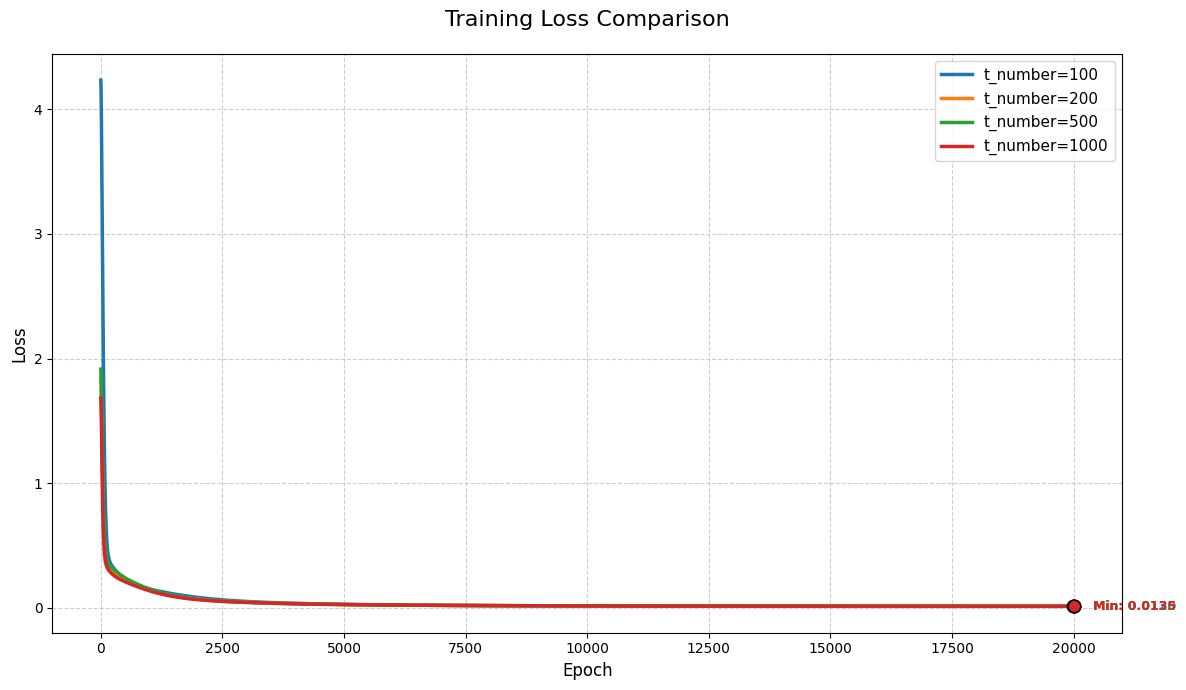

In [5]:
num_samples = 1000
x_min, x_max = -2, 7
y_min, y_max = -2, 7

feature_dims = [2048]
t_grids = [100, 200, 500, 1000]
loss_histories = []
labels = [f"t_number={p}" for p in t_grids]
fig_all, axes_all = plt.subplots(len(t_grids), 2, figsize=(16, 6 * len(t_grids)))
fig_all.suptitle('Sampling Results Comparison Across Models', fontsize=22, y=0.98)
data_dim = data.shape[1:]

torch.manual_seed(42) 
z_grid = torch.randn(500, *data_dim, device=device)

for idx, p in enumerate(t_grids):
    print(f"\n=== Training Model {idx+1}/{len(t_grids)} with t_grid_size={p} ===")

    model = RandomFeatureModel(input_dim = input_dim, feature_dim = 2048, K_t=K_t, T=T).to(device)
    
    # loss_history, model = train_random(model, data_repeated, lr=0.01, T = T, device=device)
    loss_history, model = train(model, data, z_grid, lr=0.001, T = T, device=device, t_grid_size=p)
    loss_histories.append(loss_history)

    samples = sample_exponential(model, num_samples=num_samples, T = T, device=device)
    samples_np = samples.cpu().numpy()
    data_np = data.cpu().numpy()

    print(f"Creating individual and combined visualizations for Model {idx+1}...")

    fig_single, ax_single = plt.subplots(1, 2, figsize=(16, 6))
    fig_single.suptitle(f'Model with t_grid_size={p}', fontsize=18)

    ax_single[0].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.7, color='blue', s=30, label='Generated Samples')
    ax_single[0].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', label='Original Data', zorder=5)
    ax_single[0].set_title('Generated Samples vs. Original Data', fontsize=14)
    ax_single[0].set_xlim(x_min, x_max)
    ax_single[0].set_ylim(y_min, y_max)
    ax_single[0].legend(fontsize=10)
    ax_single[0].grid(True, linestyle='--', alpha=0.6)
    ax_single[0].set_aspect('equal', adjustable='box')

    try:
        sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], cmap="viridis", fill=True, ax=ax_single[1],
                    levels=10, cbar=True, cbar_kws={'label': 'Density'})
        ax_single[1].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', zorder=5) # 加上原始数据点
        ax_single[1].set_title('Generated Samples Density Heatmap', fontsize=14)
    except ValueError as e:
        print(f"⚠️ WARNING (Individual Plot): Could not generate KDE plot for t_grid_size={p}. Error: {e}")
        ax_single[1].text(0.5, 0.5, 'KDE Plot Failed\n(Mode Collapse?)',
                          horizontalalignment='center', verticalalignment='center',
                          transform=ax_single[1].transAxes, fontsize=12, color='red')
        ax_single[1].set_title('Generated Samples Density Heatmap (Failed)', fontsize=14)

    fig_single.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    fig_single.savefig(f"model_t_grid_size_{p}_visualization.png", dpi=150)
    plt.close(fig_single)
    print(f"✅ Saved individual plot: model_t_grid_size_{p}_visualization.png")
    

    # Left: Scatter on combined plot
    axes_all[idx][0].scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.7, color='blue', s=30)
    axes_all[idx][0].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', zorder=5)
    axes_all[idx][0].set_title(f'Model {idx+1} (t_grid_size={p}): Scatter', fontsize=14)
    axes_all[idx][0].set_xlim(x_min, x_max)
    axes_all[idx][0].set_ylim(y_min, y_max)
    axes_all[idx][0].grid(True, linestyle='--', alpha=0.6)
    axes_all[idx][0].set_aspect('equal', adjustable='box')
    axes_all[idx][0].set_ylabel('Y-axis', fontsize=12)
    
    try:
        sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], fill=True, thresh=0.0, levels=100, cmap="YlOrBr", ax=axes_all[idx][1])
        sns.kdeplot(x=samples_np[:, 0], y=samples_np[:, 1], fill=False, thresh=0.02, levels=20, cmap="coolwarm", ax=axes_all[idx][1])
        axes_all[idx][1].set_title(f'Model {idx+1} (t_grid_size={p}): Density Heatmap', fontsize=14)
    except ValueError as e:
        print(f"⚠️ WARNING (Combined Plot): Could not generate KDE plot for scaling={p}. Error: {e}")
        axes_all[idx][1].text(0.5, 0.5, 'KDE Plot Failed', horizontalalignment='center', verticalalignment='center',
                              transform=axes_all[idx][1].transAxes, fontsize=12, color='red')
        axes_all[idx][1].set_title(f'Model {idx+1} (t_grid_size={p}): Density Heatmap (Failed)', fontsize=14)
        
    axes_all[idx][1].scatter(data_np[:, 0], data_np[:, 1], color='red', marker='s', s=150, edgecolors='black', zorder=5)
    axes_all[idx][1].set_xlim(x_min, x_max)
    axes_all[idx][1].set_ylim(y_min, y_max)
    axes_all[idx][1].grid(True, linestyle='--', alpha=0.6)
    axes_all[idx][1].set_aspect('equal', adjustable='box')

    if idx == len(feature_dims) - 1:
        axes_all[idx][0].set_xlabel('X-axis', fontsize=12)
        axes_all[idx][1].set_xlabel('X-axis', fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.96])
fig_all.savefig("sampling_comparison_t_grid_size_2modes_p2048.png", dpi=300, bbox_inches='tight')
print("✅ Saved combined sampling comparison plot: sampling_comparison_t_grid_size_2modes_p2048.png")
plt.close(fig_all)

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(12, 7))

for i, (loss_hist, label) in enumerate(zip(loss_histories, labels)):
    epochs = list(range(1, len(loss_hist) + 1))
    plt.plot(epochs, loss_hist, color=f'C{i}', alpha=0.3, linewidth=1.0, label=None)  # 不加图例
    smoothed_loss = smooth_curve(loss_hist, factor=0.95)
    plt.plot(epochs, smoothed_loss, label=label, linewidth=2.5, color=f'C{i}')
    min_loss = min(loss_hist)
    min_epoch = loss_hist.index(min_loss) + 1 
    plt.scatter(min_epoch, min_loss, color=f'C{i}', s=80, edgecolors='black', zorder=5)
    plt.text(min_epoch + len(loss_hist)*0.02, min_loss, f'Min: {min_loss:.4f}', fontsize=9, color=f'C{i}', va='center', weight='bold')

plt.title("Training Loss Comparison", fontsize=16, pad=20)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig("loss_comparison_enhanced_SGD_mean_Sineembedding.png", bbox_inches='tight')
print("✅ Saved enhanced loss comparison plot: loss_comparison_enhanced.png")

print("\n🎉 All done! Models trained, sampled, and all visualizations saved.")

In [ ]:
snapshots = sample_exponential(model, num_samples=3000, num_steps=4000, T = T, device=device, num_snapshots = 401)

if snapshots:
    print("正在生成可视化图像...")
    
    total_num_snapshots = len(snapshots)
    all_snapshot_steps = torch.linspace(0, 4000, 401, dtype=int).tolist()
    
    num_to_plot = 21 #只绘制最后的21个
    if total_num_snapshots > num_to_plot:
        snapshots_to_plot = snapshots[-num_to_plot:]
        steps_to_plot = all_snapshot_steps[-num_to_plot:]
        plot_title = f"SDE Sampling process"
        print(f"快照总数为 {total_num_snapshots}，只显示最后 {num_to_plot} 个。")
    else:
        snapshots_to_plot = snapshots
        steps_to_plot = all_snapshot_steps
        plot_title = f"SDE Sampling process"
        print(f"快照总数 {total_num_snapshots} (小于等于{num_to_plot})，全部显示。")

    num_snapshots_to_plot = len(snapshots_to_plot) 
    ncols = 3 
    nrows = (num_snapshots_to_plot + ncols - 1) // ncols 
    
    fig_width = ncols * 4
    fig_height = nrows * 4

    if nrows == 0:
        print("没有快照可供显示。")
    else:
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
        if num_snapshots_to_plot == 1:
             axes_flat = [axes] 
        elif nrows == 1:
            axes_flat = axes
        else:
            axes_flat = axes.flatten()
        
        for i, snap in enumerate(snapshots_to_plot):
            data = snap.numpy()
            ax = axes_flat[i] 

            ax.scatter(data[:, 0], data[:, 1], alpha=0.3, s=10)
            ax.set_title(f"Step {steps_to_plot[i]}") 
            ax.set_aspect('equal')

        num_total_plots = nrows * ncols
        for i in range(num_snapshots_to_plot, num_total_plots):
            axes_flat[i].axis('off')

        plt.suptitle(plot_title, fontsize=16)
        save_filename = "snapshots_visualization.png" 
        plt.savefig(save_filename, dpi=300, bbox_inches='tight')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
        plt.show()

In [ ]:
num_steps_list = [2000, 5000, 10000, 20000]
num_samples = 5000 

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()  

for idx, num_steps in enumerate(num_steps_list):
    samples = sample_exponential(
        model=model,
        num_samples=num_samples,
        num_steps=num_steps,
        T=T,
        device=device,
        num_snapshots=0
    )
    samples_np = samples.cpu().numpy()  # 转换为NumPy数组
    
    # 绘制散点图
    ax = axes[idx]
    scatter = ax.scatter(
        samples_np[:, 0], 
        samples_np[:, 1],
        s=3,
        alpha=0.6,
        cmap='viridis',
        c=np.arange(num_samples),
        edgecolors='none'
    )
    
    # 设置图表属性
    ax.set_title(
        f'Sample Distribution (num_steps={num_steps})',
        fontsize=14,
        pad=12
    )
    ax.set_xlabel('X-coordinate', fontsize=12)
    ax.set_ylabel('Y-coordinate', fontsize=12)
    ax.set_xlim(-2, 7)
    ax.set_ylim(-4, 4)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_aspect('equal')
    
    if idx == 0:
        cbar = fig.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Sampling Order', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle(
    'Effect of Numerical Steps on Sample Distribution',
    fontsize=16,
    fontweight='bold'
)
plt.savefig('sample_comparison_steps.png', dpi=300, bbox_inches='tight')
plt.show()